### GPU Use

In [117]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [93]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.474227178000547
GPU (s):
0.12127327600046556
GPU speedup over CPU: 45x


In [94]:
# If running on Colab, uncomment the next line
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
print('GPU not found.') if device_name != '/device:GPU:0' else print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [95]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
csv_path = "/content/drive/MyDrive/LAB/FL_paper.csv"
df = pd.read_csv(csv_path)
df.head()

,Nozzle diameter (um),Plotting Speed (mm/s),Standoff distance (um),Voltage (V),Duty ratio (%),Frequency (Hz),Line Width (um),Ink,Source,source_ID,Taylor Cone Height (um),Taylor Cone Angle,Substrate,Operator,Printer
0,50,5,125,800,NaN,NaN,45.807,Ag-191,conference_data,1,25.203624,52.564443,Glass,LJ_RY,Flight Printer
1,50,5,125,800,NaN,NaN,35.540,Ag-191,conference_data,1,24.261442,51.199519,Glass,LJ_RY,Flight Printer
2,50,5,125,800,NaN,NaN,40.542,Ag-191,conference_data,1,24.211508,50.676759,Glass,LJ_RY,Flight Printer
3,50,5,75,700,NaN,NaN,54.758,Ag-191,conference_data,1,31.798148,50.615711,Glass,LJ_RY,Flight Printer
4,50,5,125,900,NaN,NaN,52.915,Ag-191,conference_data,1,22.850992,49.076464,Glass,LJ_RY,Flight Printer


In [97]:
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned.head()

,Nozzle diameter (um),Plotting Speed (mm/s),Standoff distance (um),Voltage (V),Line Width (um),Ink,Source,source_ID,Taylor Cone Height (um),Taylor Cone Angle,Substrate,Operator,Printer
0,50,5,125,800,45.807,Ag-191,conference_data,1,25.203624,52.564443,Glass,LJ_RY,Flight Printer
1,50,5,125,800,35.540,Ag-191,conference_data,1,24.261442,51.199519,Glass,LJ_RY,Flight Printer
2,50,5,125,800,40.542,Ag-191,conference_data,1,24.211508,50.676759,Glass,LJ_RY,Flight Printer
3,50,5,75,700,54.758,Ag-191,conference_data,1,31.798148,50.615711,Glass,LJ_RY,Flight Printer
4,50,5,125,900,52.915,Ag-191,conference_data,1,22.850992,49.076464,Glass,LJ_RY,Flight Printer


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

target = 'Line Width (um)'
y = df_cleaned[target]
X = df_cleaned.drop(columns=[target])

### RandomForestRegressor Model

preprocessing : scikit-learn Pipeline & ColumnTransformer

In [99]:
numeric_features = [
    'Nozzle diameter (um)',
    'Plotting Speed (mm/s)',
    'Standoff distance (um)',
    'Voltage (V)',
    'Taylor Cone Height (um)',
    'Taylor Cone Angle'
]

categorical_features = [
    'Ink',
    'Source',
    'Substrate',
    'Operator',
    'Printer'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [100]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [101]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
pipeline.fit(X_train, y_train)
print("model trained")

model trained


In [104]:
print("model results")
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")

model results
Mean Absolute Error (MAE): 9.184
Mean Squared Error (MSE): 252.925
Root Mean Squared Error (RMSE): 15.904
R-squared (R²): 0.610



Plot 1: 'Actual vs. Predicted'


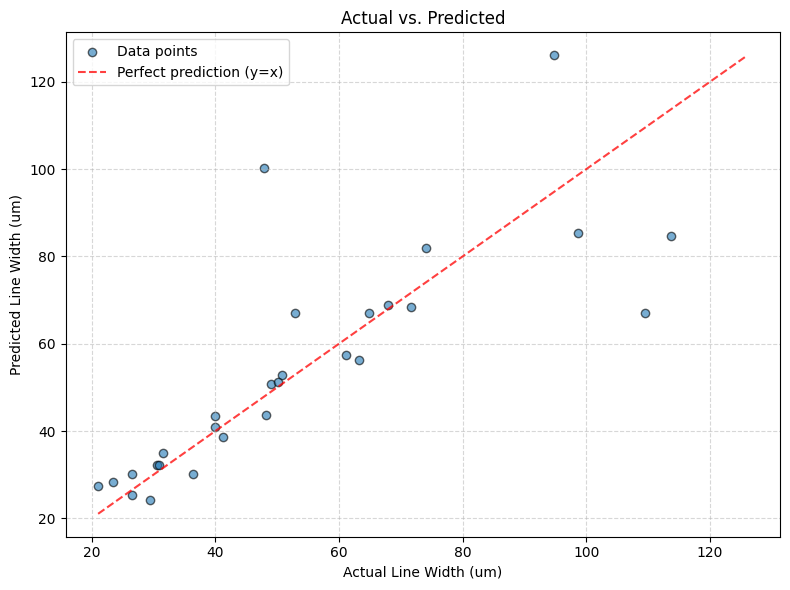


Plot 2: 'Residuals vs. Predicted'


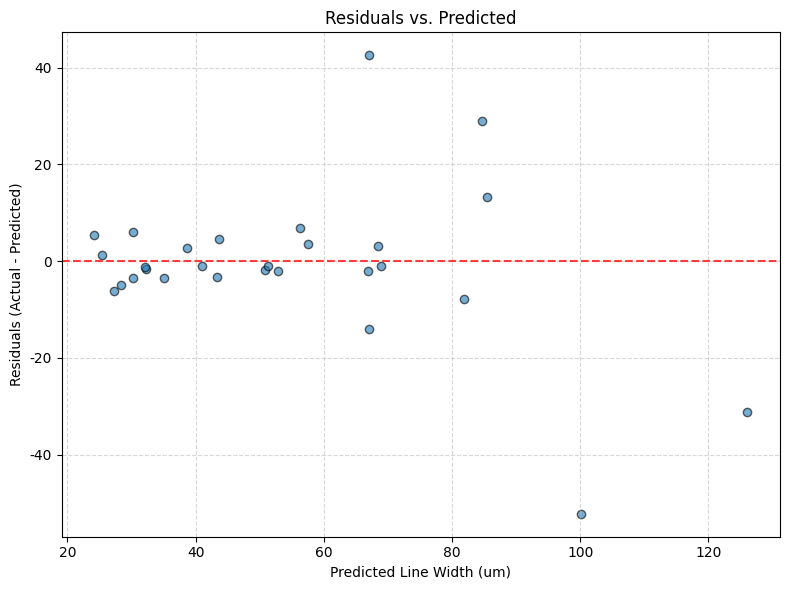


Plot 3: 'Feature Importance'


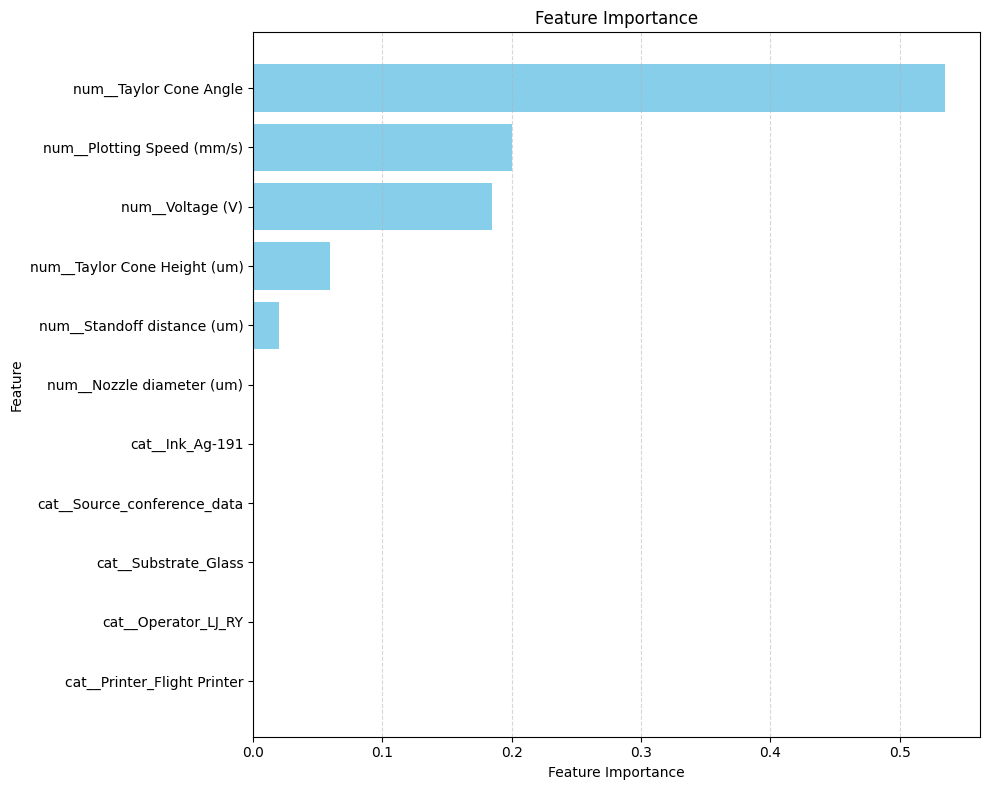

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot 1
print("\nPlot 1: 'Actual vs. Predicted'")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', label='Data points')

lims = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect prediction (y=x)')
plt.xlabel("Actual Line Width (um)")
plt.ylabel("Predicted Line Width (um)")
plt.title("Actual vs. Predicted")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot 2
print("\nPlot 2: 'Residuals vs. Predicted'")
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')

plt.axhline(y=0, color='r', linestyle='--', alpha=0.75)
plt.xlabel("Predicted Line Width (um)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot 3
print("\nPlot 3: 'Feature Importance'")
model_in_pipeline = pipeline.named_steps['model']
preprocessor_in_pipeline = pipeline.named_steps['preprocessor']

try:
    feature_names = preprocessor_in_pipeline.get_feature_names_out()
except AttributeError:
    ohe_categories = preprocessor_in_pipeline.named_transformers_['cat'].named_steps['onehot'].categories_
    new_ohe_features = [f"{col}_{cat}" for i, col in enumerate(categorical_features) for cat in ohe_categories[i]]
    feature_names = numeric_features + new_ohe_features

importances = model_in_pipeline.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
num_features_to_plot = min(len(importance_df), 20)
top_features = importance_df.head(num_features_to_plot)

plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Feature Importance")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5, axis='x')
plt.tight_layout()
plt.show()

### XGBoost

In [67]:
pip install xgboost

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

try:
    df = pd.read_csv(csv_path)
    df_cleaned = df.dropna(axis=1, how='all')

    target = 'Line Width (um)'
    if target not in df_cleaned.columns:
        print(f"No '{target}'.")
    else:
        y = df_cleaned[target]
        X = df_cleaned.drop(columns=[target])

        numeric_features = X.select_dtypes(include=np.number).columns.tolist()

        # removing 'source_ID'
        if 'source_ID' in numeric_features:
            numeric_features.remove('source_ID')

        categorical_features = ['Ink', 'Source', 'Substrate', 'Operator', 'Printer']
        categorical_features = [col for col in categorical_features if col in X.columns]

        print(f"numeric features: {numeric_features}")
        print(f"categorical features: {categorical_features}")

        # Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ])
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='drop'
        )

        X_train_sub, X_val, y_train_sub, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )

        # 7. XGBoost Model
        model_xgb = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            early_stopping_rounds=10,
            random_state=42
        )

        pipeline_xgb = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model_xgb)
            ])

        preprocessor.fit(X_train_sub, y_train_sub)

        X_val_transformed = preprocessor.transform(X_val)

        # Model Training
        pipeline_xgb.fit(
            X_train_sub,
            y_train_sub,
            model__eval_set=[(X_val_transformed, y_val)],
            model__verbose=False
        )

        print("model trained")

        # Model Evaluation
        print("\nXGBoost Result")
        y_pred_xgb = pipeline_xgb.predict(X_test)

        mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
        mse_xgb = mean_squared_error(y_test, y_pred_xgb)
        rmse_xgb = np.sqrt(mse_xgb)
        r2_xgb = r2_score(y_test, y_pred_xgb)

        print(f"Mean Absolute Error (MAE): {mae_xgb:.3f}")
        print(f"Mean Squared Error (MSE): {mse_xgb:.3f}")
        print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.3f}")
        print(f"R-squared (R²): {r2_xgb:.3f}")

except Exception as e:
    print(f"Unexpected Error: {e}")

numeric features: ['Nozzle diameter (um)', 'Plotting Speed (mm/s)', 'Standoff distance (um)', 'Voltage (V)', 'Taylor Cone Height (um)', 'Taylor Cone Angle']
categorical features: ['Ink', 'Source', 'Substrate', 'Operator', 'Printer']
model trained

XGBoost Result
Mean Absolute Error (MAE): 7.936
Mean Squared Error (MSE): 200.268
Root Mean Squared Error (RMSE): 14.152
R-squared (R²): 0.691



Plot 1: 'Actual vs. Predicted'


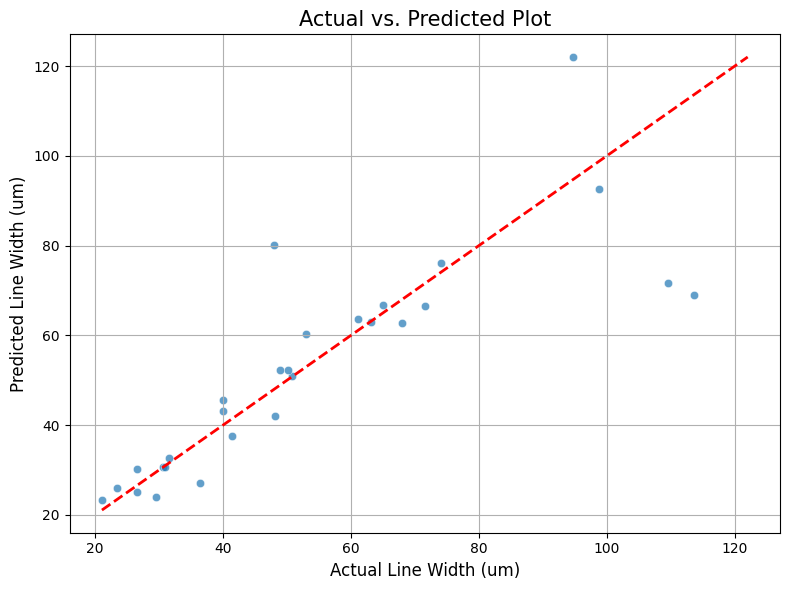

Plot 2: 'Residuals vs. Predicted'


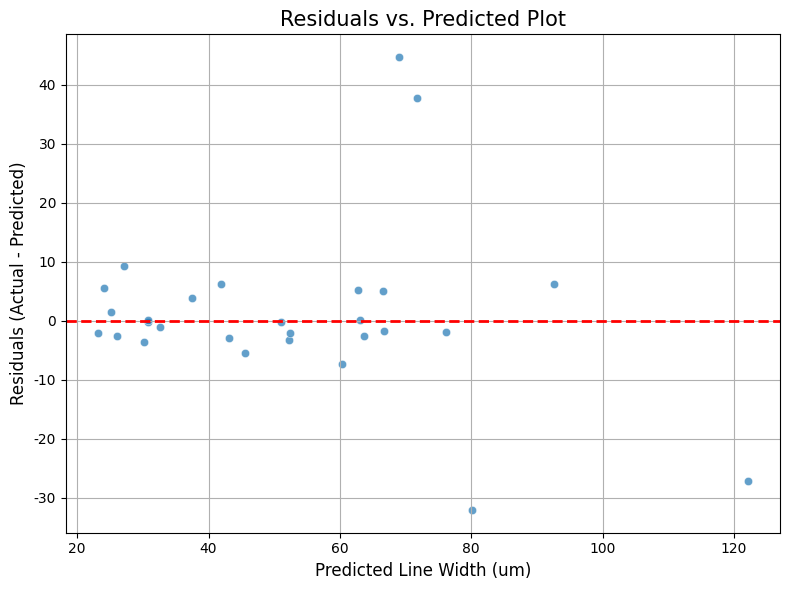

Plot 3: 'Feature Importance'


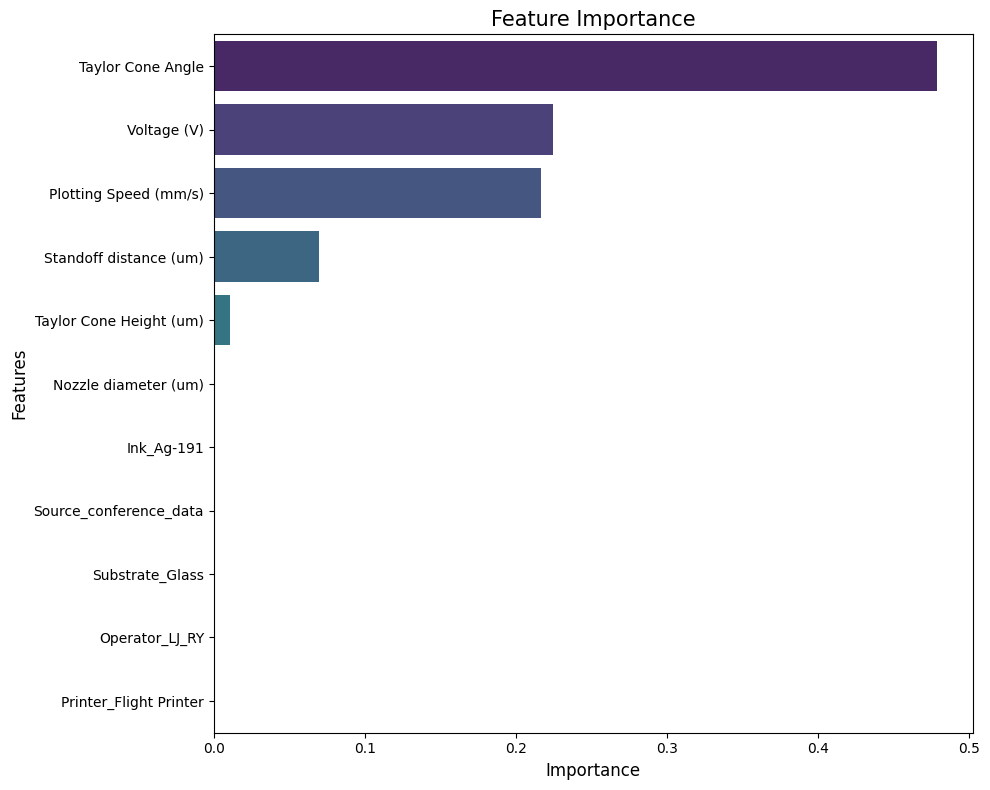

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

try:
    plt.rc('font', family='DejaVu Sans')
    plt.rcParams['axes.unicode_minus'] = False


    y_pred_xgb = pipeline_xgb.predict(X_test)

    # Plot 1
    print("\nPlot 1: 'Actual vs. Predicted'")
    plt.figure(figsize=(8, 6))

    min_val = min(y_test.min(), y_pred_xgb.min())
    max_val = max(y_test.max(), y_pred_xgb.max())

    sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    plt.xlabel("Actual Line Width (um)", fontsize=12)
    plt.ylabel("Predicted Line Width (um)", fontsize=12)
    plt.title("Actual vs. Predicted Plot", fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2
    print("Plot 2: 'Residuals vs. Predicted'")
    residuals = y_test - y_pred_xgb

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred_xgb, y=residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--', lw=2)

    plt.xlabel("Predicted Line Width (um)", fontsize=12)
    plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
    plt.title("Residuals vs. Predicted Plot", fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3
    print("Plot 3: 'Feature Importance'")

    model_xgb = pipeline_xgb.named_steps['model']
    preprocessor = pipeline_xgb.named_steps['preprocessor']

    ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    final_feature_names = numeric_features + list(ohe_feature_names)

    importances = model_xgb.feature_importances_

    if len(importances) == len(final_feature_names):
        feat_imp = pd.Series(importances, index=final_feature_names).sort_values(ascending=False)

        if len(feat_imp) > 20:
            feat_imp = feat_imp.head(20)
            plot_title = "Feature Importance)"
        else:
            plot_title = "Feature Importance"

        plt.figure(figsize=(10, 8))
        sns.barplot(x=feat_imp.values, y=feat_imp.index, hue=feat_imp.index, palette='viridis', legend=False)
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.title(plot_title, fontsize=15)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning. : {len(importances)} vs {len(final_feature_names)})")

except NameError as e:
    print(f"\nCan't find feature :({e}).")